O presente documento foi inspirado nesse notebook: https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

Aqui será utilizado esse conjunto de dados [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata).

**Existem 3 tipos de sistemas de recomendação:**

> * **Filtro Demográfico** - Eles oferecem recomendações generalizadas para cada usuário, com base na popularidade e / ou gênero do filme. O Sistema recomenda os mesmos filmes para usuários com características demográficas semelhantes. Como cada usuário é diferente, essa abordagem é considerada muito simples. A ideia básica por trás desse sistema é que os filmes mais populares e aclamados pela crítica terão maior probabilidade de serem apreciados pelo público médio.



> * **Filtragem baseada em conteúdo** - Eles sugerem itens semelhantes com base em um item específico. Este sistema usa metadados de itens, como gênero, diretor, descrição, atores, etc. para filmes, para fazer essas recomendações. A ideia geral por trás desses sistemas de recomendação é que, se uma pessoa gostou de um determinado item, também gostará de um item semelhante a ele.

> * **Filtragem colaborativa** - Este sistema combina pessoas com interesses semelhantes e fornece recomendações com base nessa correspondência. Os filtros colaborativos não requerem metadados de itens como suas contrapartes baseadas em conteúdo.

Vamos carregar os dados

In [ ]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
#how to set index
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html

> O primeiro conjunto de dados (tmdb_5000_credits.csv) contém os seguintes recursos

* movie_id - Um identificador único para cada filme.
* cast - O nome dos atores principais e coadjuvantes.
* crew - O nome do Diretor, Editor, Compositor, Escritor etc.

In [ ]:
df1.head()

O segundo conjunto de dados possui as seguintes características:

* budget - O orçamento em que o filme foi feito.
* genre - O gênero do filme, ação, comédia, suspense etc.
* homepage - Um link para a página inicial do filme.
* id - Este é, de fato, o movie_id como no primeiro conjunto de dados.
* keywords - As palavras-chave ou tags relacionadas ao filme.
* original_language - O idioma em que o filme foi feito.
* original_title - O título do filme antes da tradução ou adaptação.
* overview - Uma breve descrição do filme.
* popularity - Uma quantidade numérica que especifica a popularidade do filme.
* production_companies - A casa de produção do filme.
* production_countries - O país em que foi produzido.
* release_date - A data em que foi lançado.
* revenue - A receita mundial gerada pelo filme.
* runtime - O tempo de execução do filme em minutos.
* status - "Lançado" ou "Rumor".
* tagline - Slogan do filme.
* title - Título do filme.
* vote_average - classificações médias que o filme recebeu.
* vote_count - a contagem dos votos recebidos.

Vamos juntar os dois conjuntos de dados na coluna 'id'


In [ ]:
df1.columns = ['id','tittle','cast','crew'] #renomeando as colunas para concatenação, move_id vai ser id agora!
df2= df2.merge(df1,on='id') #mergiando e definindo qual o identificador para ser usado como chave primária

Basta dar uma olhada em nossos dados.

In [ ]:
df2.info()

In [ ]:
df2.head(5)

# **Filtragem demográfica** -
Antes de começar com isso -
* precisamos de uma métrica para pontuar ou avaliar o filme
* Calcule a pontuação de cada filme
* Classifique as pontuações e recomende o filme com melhor classificação aos usuários.

Podemos usar as classificações médias do filme como pontuação, mas usar isso não será justo, pois um filme com classificação média de 8,9 e apenas 3 votos não pode ser considerado melhor do que o filme com classificação média de 7,8, mas 40 votos.
Portanto, usarei a classificação ponderada do IMDB (wr), que é fornecida como :-

![](https://image.ibb.co/jYWZp9/wr.png)
onde:
* v é o número de votos do filme;
* m é o número mínimo de votos exigidos para serem listados no gráfico;
* R é a avaliação média do filme;
* C é o voto médio global, utilizando todos os dados disponíveis;

Já temos v (**vote_count**) e R (**vote_average**) e C pode ser calculado como

In [ ]:
C= df2['vote_average'].mean()
C

Portanto, a classificação média para todos os filmes é de aproximadamente 6 em uma escala de 10. 
A próxima etapa é determinar um valor apropriado para m, os votos mínimos necessários para serem listados no gráfico. 
Usaremos o percentil 90 como nosso ponto de corte. 
Em outras palavras, para um filme figurar nas paradas, ele deve ter mais votos do que pelo menos 90% dos filmes da lista.

In [ ]:
m= df2['vote_count'].quantile(0.9)
m

Agora, podemos filtrar os filmes que se qualificam para o gráfico

In [ ]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

In [ ]:
q_movies.head()

Vemos que existem 481 filmes que se qualificam para esta lista. 
Agora, precisamos calcular nossa métrica para cada filme qualificado. 
Para fazer isso, definiremos uma função **weighted_rating()** e definiremos um novo recurso **score**, do qual calcularemos o valor aplicando esta função ao nosso DataFrame de filmes qualificados:

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [ ]:
q_movies.head()

Finalmente, vamos ordenar o dataframe baseado no score e mostrar os 10 filmes com melhor score

In [ ]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

Usando o vote average

In [ ]:
df2_q = df2.sort_values('vote_count', ascending=False)

#Print the top 10 movies
df2_q[['title', 'vote_count', 'vote_average']].head(10)

Muitos sistemas de recomendação apenas mostram os filmes mais populares, vamos construir um gráfico para mostrar como seria

In [ ]:
df2_q = df2.sort_values('vote_average', ascending=False)

#Print the top 10 movies
df2_q[['title', 'vote_count', 'vote_average']].head(10)

In [ ]:
pop= df2.sort_values('popularity', ascending=False).head(10)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.barh(pop['title'],pop['popularity'], align='center', color='red')
plt.gca().invert_yaxis() # para mostrar essa 
plt.xlabel("Popularity")
plt.title("Popular Movies")


Agora, algo para se ter em mente é que esses recomendadores demográficos fornecem um gráfico geral de filmes recomendados para todos os usuários. Eles não são sensíveis aos interesses e gostos de um usuário específico.
É então que passamos para um sistema mais refinado - Filtragem de base de conteúdo.

# **Filtragem Baseada em Conteúdo**
Neste sistema de recomendação, o conteúdo do filme (visão geral, elenco, equipe, palavra-chave, slogan, etc.) é usado para encontrar sua semelhança com outros filmes. 

Então, os filmes com maior probabilidade de serem semelhantes são recomendados.

![](https://image.ibb.co/f6mDXU/conten.png)

Nós calcularemos as pontuações de similaridade em pares para todos os filmes com base em suas descrições de enredo e recomendaremos filmes com base nessa pontuação de similaridade. 
A descrição do gráfico é fornecida na coluna **overview** do nosso conjunto de dados.

Vamos dar uma olhada nos dados. ..

In [ ]:
df2.head(5)

In [ ]:
df2['overview'].head(5)

Precisamos converter o vetor de palavras de cada overview.
Para tal, calcularemos os vetores Term Frequency-Inverse Document Frequency (TF-IDF) para cada overview.
TF-IDF é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos

Isso lhe dará uma matriz onde cada coluna representa uma palavra no vocabulário geral (todas as palavras que aparecem em pelo menos um documento) e cada linha representa um filme, como antes. Isso é feito para reduzir a importância das palavras que ocorrem com frequência em visões gerais de plotagem e, portanto, sua importância no cálculo da pontuação final de similaridade.

Felizmente, o scikit-learn oferece uma classe TfIdfVectorizer integrada que produz a matriz TF-IDF em algumas linhas. Isso é ótimo, não é?

In [ ]:
#Importar TfIdfVectorizer do scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english') #TfidfVectorizer(stop_words='portuguese') 

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

Vemos que mais de 20.000 palavras diferentes foram usadas para descrever os 4800 filmes em nosso conjunto de dados.

Com essa matriz em mãos, agora podemos calcular uma pontuação de similaridade. Existem vários candidatos para isso; como o euclidiano, o Pearson e o pontuações de similaridade de cosseno (https://en.wikipedia.org/wiki/Cosine_similarity). Não existe uma resposta certa para qual pontuação é a melhor. Pontuações diferentes funcionam bem em cenários diferentes e, muitas vezes, é uma boa ideia experimentar métricas diferentes.

Estaremos usando a similaridade do cosseno para calcular uma quantidade numérica que denota a similaridade entre dois filmes. Usamos a pontuação de similaridade do cosseno, pois é independente da magnitude e é relativamente fácil e rápido de calcular. Matematicamente, é definido da seguinte forma:
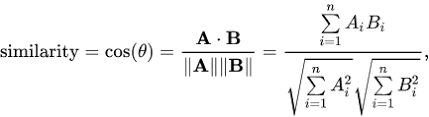

Como usamos o vetorizador TF-IDF, o cálculo do produto escalar nos dará diretamente a pontuação de similaridade do cosseno. 
Portanto, usaremos **linear_kernel()** de sklearn em vez de cosine_similarities(), pois é mais rápido.

In [ ]:
# Import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim

Vamos definir uma função que recebe o título de um filme como entrada e gera uma lista dos 10 filmes mais semelhantes. 
Em primeiro lugar, para isso, precisamos de um mapeamento reverso de títulos de filmes e índices DataFrame. 
Em outras palavras, precisamos de um mecanismo para identificar o índice de um filme em nosso DataFrame de metadados, dado seu título.

In [ ]:
#Construa um mapa reverso de índices e títulos de filmes
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()
type(indices)

In [ ]:
indices.head()

Agora estamos em uma boa posição para definir nossa função de recomendação. Estas são as seguintes etapas que seguiremos: -
* Obtenha o índice do filme dado seu título.
* Obtenha a lista de pontuações de similaridade de cosseno para aquele filme específico com todos os filmes. Converta-o em uma lista de tuplas em que o primeiro elemento é sua posição e o segundo é a pontuação de similaridade.
* Classifique a lista de tuplas mencionada acima com base nas pontuações de similaridade; ou seja, o segundo elemento.
* Obtenha os 10 principais elementos desta lista. Ignore o primeiro elemento, pois ele se refere a si mesmo (o filme mais semelhante a um determinado filme é o próprio filme).
* Retorne os títulos correspondentes aos índices dos elementos principais.

Simulando filme: 
    Spider-Man 3                                      
    Index: 5

In [ ]:
# Obtenha o índice do filme que corresponde ao título
idx = indices['Spider-Man 3']
idx

In [ ]:
# Obtenha as pontuações de semelhança entre pares de todos os filmes com aquele filme
sim_scores = list(enumerate(cosine_sim[idx]))
#type(sim_scores)
#print(sim_scores)


In [ ]:
# Classifique os filmes com base nas pontuações de similaridade
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#print(sim_scores)

In [ ]:
# Obtenha as pontuações dos 10 filmes mais semelhantes
sim_scores = sim_scores[1:11]
sim_scores

In [ ]:
# Obtenha os índices de filmes
movie_indices = [i[0] for i in sim_scores]
movie_indices

In [ ]:
# Retorne os 10 principais filmes mais semelhantes
df2['title'].iloc[movie_indices]

In [ ]:
# Função que recebe o título do filme como entrada e produz a maioria dos filmes semelhantes
def get_recommendations(title, cosine_sim=cosine_sim):
    # Obtenha o índice do filme que corresponde ao título
    idx = indices[title]

    # Obtenha as pontuações de semelhança entre pares de todos os filmes com aquele filme
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Classifique os filmes com base nas pontuações de similaridade
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtenha as pontuações dos 10 filmes mais semelhantes
    sim_scores = sim_scores[1:11]

    # Obtenha os índices de filmes
    movie_indices = [i[0] for i in sim_scores]

    # Retorne os 10 principais filmes mais semelhantes
    return df2['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Dark Knight Rises')

In [ ]:
get_recommendations('Avatar')

In [ ]:
get_recommendations('The Avengers')

A recomendação pode ser boa, mas o overview de dois filmes podem ser diferentes e mesmo assim eles podem ser boas recomendações para um usuário.
Para não utilizar apenas a descrição do filme como fator de recomendação, podemos utilizar a filtragem colaborativa 

# **Filtragem Colaborativa (CF)**
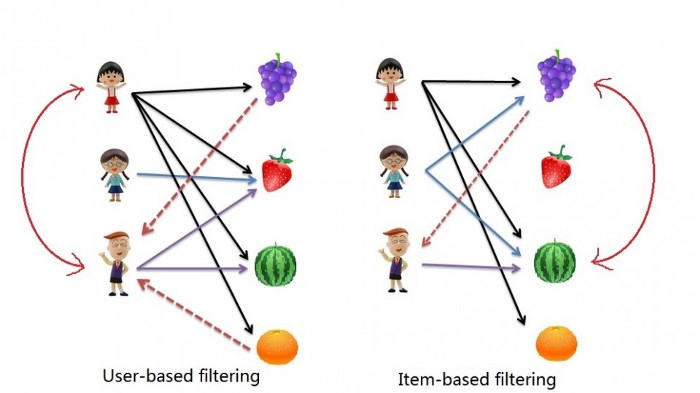

Nosso mecanismo baseado em conteúdo sofre de algumas limitações severas. Ele só é capaz de sugerir filmes próximos a um determinado filme. Ou seja, não é capaz de capturar gostos e fornecer recomendações entre gêneros.

Além disso, o mecanismo que construímos não é realmente pessoal, pois não captura os gostos e preconceitos pessoais de um usuário. 
Qualquer pessoa que consultar nosso mecanismo para recomendações baseadas em um filme receberá as mesmas recomendações para aquele filme, independentemente de quem ele / ela seja.

Portanto, nesta seção, usaremos uma técnica chamada Filtragem Colaborativa para fazer recomendações aos Movie Watchers.
É basicamente de dois tipos:

*  **Filtragem baseada em usuário**-  Esses sistemas recomendam produtos para um usuário que usuários semelhantes gostaram. Para medir a similaridade entre dois usuários, podemos usar a correlação de Pearson ou a similaridade de cosseno.

* **Filtragem baseada em item** - Em vez de medir a semelhança entre os usuários, o CF baseado em item recomenda itens com base em sua semelhança com os itens que o usuário-alvo classificou. Da mesma forma, a similaridade pode ser calculada com correlação de Pearson ou similaridade de cosseno.

Probleas podem ser elencados:  
Problema 1: ***escalabilidade***. O cálculo cresce com o cliente e com o produto. 

Problema 2: ***esparsidade***. Vários filmes não vão ter avaliação


### **Single Value Decomposition**

Uma maneira de lidar com o problema de escalabilidade e dispersão criado pelo CF é utilizar um **Single Value Decomposition** para capturar a semelhança entre usuários e itens. Essencialmente, queremos transformar o problema de recomendação em um problema de otimização. Podemos ver como somos bons em prever a classificação de itens dado um usuário. Uma métrica comum é Root Mean Square Error (RMSE). **Quanto menor o RMSE, melhor será o desempenho**.

Agora, falando sobre fator latente, você pode estar se perguntando o que é? 

É uma ideia ampla que descreve uma propriedade ou conceito que um usuário ou um item tem. Por exemplo, para música, o fator latente pode se referir ao gênero ao qual a música pertence. 
SVD diminui a dimensão da matriz de utilidade, extraindo seus fatores latentes. 
Essencialmente, mapeamos cada usuário e cada item em um espaço latente com dimensão r. 
Portanto, isso nos ajuda a entender melhor a relação entre usuários e itens à medida que se tornam diretamente comparáveis. 

A figura abaixo ilustra essa ideia.

![](https://cdn-images-1.medium.com/max/800/1*GUw90kG2ltTd2k_iv3Vo0Q.png)

Dito isso, vamos ver como implementar isso.
Como o conjunto de dados que usamos antes não tinha userId (que é necessário para a filtragem colaborativa), vamos carregar outro conjunto de dados. 

Estaremos usando a [**Surpresa**]
(https://surprise.readthedocs.io/en/stable/index.html) biblioteca para implementar o SVD.

In [ ]:
#https://surprise.readthedocs.io/en/stable/getting_started.html
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.head()

Note that in this dataset movies are rated on a scale of 5 unlike the earlier one.

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
#data.split(n_folds=5)

In [ ]:
svd = SVD()
#knn = KNNBasic()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
#indicaivo de que serão construídas boas predições com o conjunto de dados em questão
#https://www.linkedin.com/pulse/rmse-ou-mae-como-avaliar-meu-modelo-de-machine-learning-rezende/?originalSubdomain=pt

Obtemos um erro médio quadrático médio de 0,89 aprox, que é mais do que bom o suficiente para nosso caso. Vamos agora treinar em nosso conjunto de dados e chegar às previsões.

In [ ]:
data

In [ ]:
trainset = data.build_full_trainset() # Do not split the dataset into folds and just return a trainset as is, built from the whole dataset.
svd.fit(trainset)

Vamos escolher o usuário com ID de usuário 1 e verificar as avaliações que ele / ela deu.

In [ ]:
ratings[ratings['userId'] == 1]

In [ ]:
svd.predict(1, 3671, verbose=True).est # user, item, r_ui
#r_ui: https://stackoverflow.com/questions/62723847/what-is-the-use-of-r-ui-true-rating-argument-in-sklearn-surprise-predict-meth

## **Conclusion** 
Criamos recomendadores usando filtragem demográfica, baseada em conteúdo e colaborativa. 
Embora a filtragem demográfica seja muito elementar e não possa ser usada na prática, os **Sistemas Híbridos** podem tirar proveito da filtragem colaborativa e baseada em conteúdo, pois as duas abordagens são comprovadamente complementares.
Este modelo foi muito básico e fornece apenas uma estrutura fundamental para começar.

Referências:
https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

1. [https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75](https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75)
2. [https://www.kaggle.com/rounakbanik/movie-recommender-systems](https://www.kaggle.com/rounakbanik/movie-recommender-systems)
3. [http://trouvus.com/wp-content/uploads/2016/03/A-hybrid-movie-recommender-system-based-on-neural-networks.pdf](http://trouvus.com/wp-content/uploads/2016/03/A-hybrid-movie-recommender-system-based-on-neural-networks.pdf)
